In [279]:
#imports
import twint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import datetime

In [30]:
#optimus
from optimus import Optimus
op = Optimus()

In [31]:
#compatibility issues
import nest_asyncio
nest_asyncio.apply()

In [98]:
#more imports
from textblob import TextBlob
from pyspark.sql.functions import udf, col, avg
from pyspark.sql.types import DoubleType

In [46]:
#disable printing
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [33]:
#set up TWINT
c = twint.Config()

In [262]:
#get sentiment
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return -1.0 # Negative

In [263]:
# UDF to write sentiment on DF
sentiment = udf(apply_blob, DoubleType())

In [264]:
#to pandas dataframe
def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

In [265]:
#gets average sentiment for certain day on scale of 0.0 to 2.0 (neg to pos)
def tweets_sentiment(search, day):
    c.Search = search
    # Custom output format
    c.Format = "Username: {username} |  Tweet: {tweet}"
    c.Limit = 5
    c.Since = day.strftime("%Y-%m-%d %H:%M:%S")
    c.Until = (day + datetime.timedelta(days=1)).strftime("%Y-%m-%d %H:%M:%S")
    c.Pandas = True
    with HiddenPrints():
        print(twint.run.Search(c))
    
    # Transform tweets to pandas DF
    df_pd = twint_to_pandas(["date", "username", "tweet"])
    
    # Transform Pandas DF to Optimus/Spark DF
    df = op.create.data_frame(pdf= df_pd)
    
    # Clean tweets
    clean_tweets = df.cols.remove_accents("tweet") \
                 .cols.remove_special_chars("tweet")
    
    # Add sentiment to final DF
    sentcol = clean_tweets.withColumn("sentiment",    sentiment(clean_tweets['tweet'])).select("*").toPandas()
    return sentcol["sentiment"].mean()

In [286]:
def sentiment_over_time(search, years, deltaday):
    #create list of datetime objects for every day from now until years ago, base is yesterday, every 5 days
    base = datetime.datetime.today() - datetime.timedelta(days=1)
    date_list = [(base - datetime.timedelta(days=x)).date() for x in list(range(years*365))[0::deltaday]]
    #create list of sentiments
    sentiment_list = [(tweets_sentiment(search, date)) for date in date_list]
    #store as pandas df
    d = {'Date': date_list, 'Sentiment': sentiment_list}
    df = pd.DataFrame(d)
    #make dates split into month day year
    df['Year'] = df['Date'].apply(lambda date: date.year)
    df['Month'] = df['Date'].apply(lambda date: date.month)
    df['Day'] = df['Date'].apply(lambda date: date.day)
    df['MonthYear'] = df['Date'].apply(lambda date: date.strftime("%m/%Y"))
    df.drop("Date", axis=1, inplace=True)
    return df

In [308]:
def get_timeline(search, years, deltaday):
    df = sentiment_over_time(search, years, deltaday)
    df = df.iloc[::-1]
    
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(15,10)})
    ax = sns.barplot(x="MonthYear", y="Sentiment", data=df, palette="vlag")
    ax.axhline(0, color="k", clip_on=False)
    title = "Twitter Sentiment Timeline for {}".format(search)
    ax.set(xlabel="Date", ylabel="+/- Sentiment", title=title)
    plt.ylim(-1,1)
    return ax

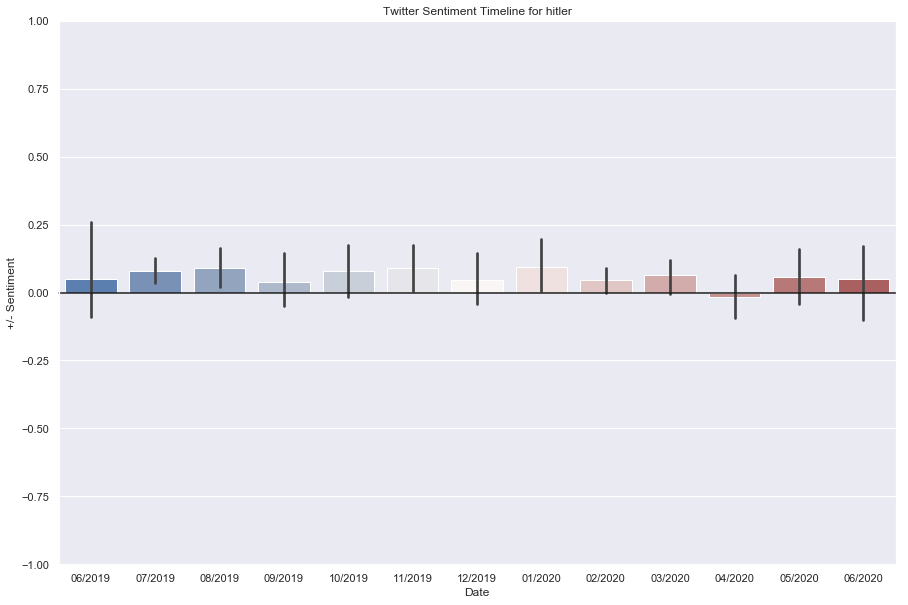

In [310]:
get_timeline("hitler", 1, 3)

In [311]:
df = sentiment_over_time("jk rowling", 1, 3)
df = df.iloc[::-1]